# MCMC <h3 style="color:green">(Metropolis-Hastings)</h3>

_Adapted from Josep Fortiana (2023-04-24) by Jordi Abante (2024-04-29)_

From Bolstad (2010), _Understanding computational Bayesian Statistics,_ Chap. 6, Example 8.   

Build a Metropolis-Hastings algorithm with target pdf:


$$
    g(\theta)  \propto 0.8\times \exp\{-\frac{1}{2}\,\theta^{2}\}
        +0.2\times \frac{1}{2}\, \exp\{-\frac{1}{2}\,\frac{(\theta-3)^{2}}{2^{2}}\},
$$

a mixture of two Gaussians, a $\operatorname{N}(0,1)$ and a $\operatorname{N}(3,4)$.

# (1) Preliminary work

$ g$ is written as a non-normalized pdf, since that is all we need for MH. 

However, the normalization constant here is known ($1/\sqrt{2\pi}$). 

Furthermore, we know how to simulate a mixture. Then, plot this pdf, generate a sequence of (independent) random numbers $\sim g$, comparing the histogram with the pdf. 

Find the sample size needed to obtain a good (or, at least, acceptable) proximity to the target pdf.

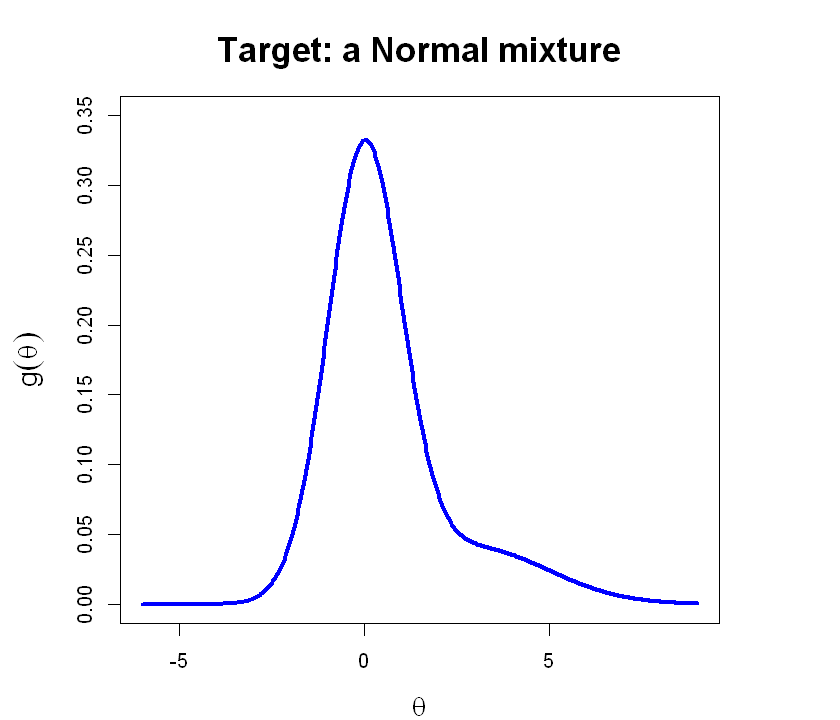

In [1]:
gamma<-0.8
m1<-0
sd1<-1
m2<-3
sd2<-2
options(repr.plot.width=7.0,repr.plot.height=6.0)
g<-function(theta){gamma*dnorm(theta,mean=m1,sd=sd1)+(1-gamma)*dnorm(theta,mean=m2,sd=sd2)}
u<-seq(-6,9,length=600)
old.par<-par(mar=c(4,5,4,5))
plot(u,g(u),type="l",lwd=3.5,ylim=c(0,0.35),col="blue",main="Target: a Normal mixture",
     xlab=expression(theta),ylab=expression(g(theta)),cex.lab=1.4,cex.main=1.7)
par(old.par)

## Generate an independent sample for this mixture pdf

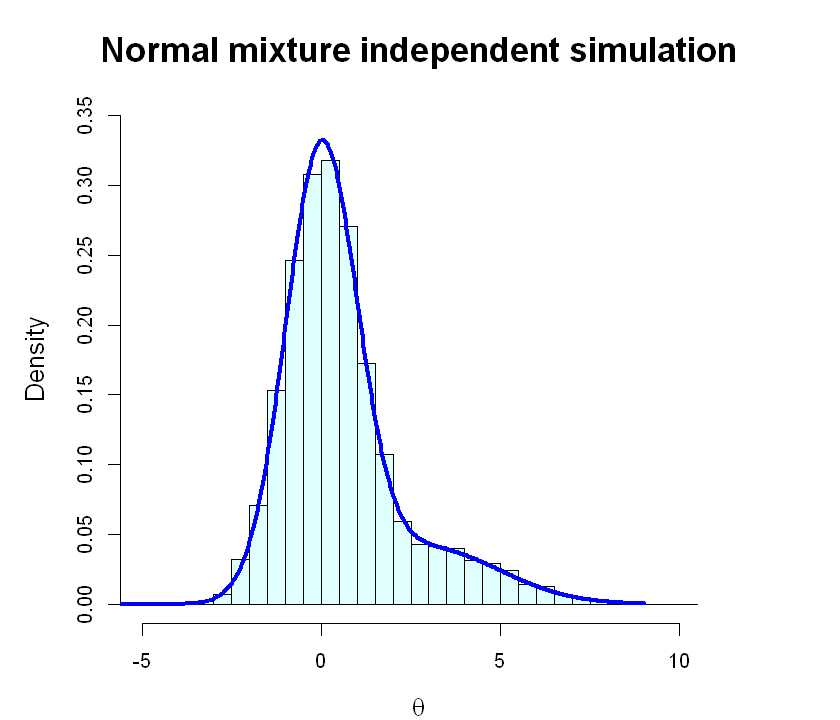

In [2]:
N<-10000
Ind<-rbinom(N,size=1,prob=gamma)
t<-Ind*rnorm(N,mean=m1,sd=sd1)+(1-Ind)*rnorm(N,mean=m2,sd=sd2)
options(repr.plot.width=7.0,repr.plot.height=6.0)
old.par<-par(mar=c(4,5,4,5))
hist(t,freq=FALSE,ylim=c(0,0.35),breaks=35,xlab=expression(theta),
    main="Normal mixture independent simulation",col="LightCyan",
    cex.main=1.7,cex.lab=1.3)
u<-seq(-6,9,length=600)
lines(u,g(u),lwd=3.5,col="blue")
par(old.par)

# (2) Metropolis-Hastings code with a normal random walk

$$
    k(\theta'\mid\theta)=\exp\{-\frac{1}{2}(\theta'-\theta)^{2}\}.
$$

With this candidate proposal kernel, the probability of acceptance in the Metropolis-Hastings formula is:

$$
    \min\left\{1,\frac{h_{x}(\theta')\,k(\theta\,\mid\theta')}
            {h_{x}(\theta)\,k(\theta'\mid\theta)}\right\}
            =\min\left\{1,\frac{h_{x}(\theta')}{h_{x}(\theta)}\right\}.
$$

The symmetry of the candidate generation implies this M-H algorithm reduces to the simple Metropolis algorithm. 

_Hint:_ Use $ \theta=2$ as the start value in the trajectory. 

Test the algorithm with several values of chain length and _burn-in_ initial discarded segment.

## Candidate proposal kernel

Here 

$$
    k(t_1\,|\,t)=\exp\big(\,-(t_1-t)^2/2\,\big).
$$

That is: the difference $ t_1-t$ follows a standard $\textrm{N}(0,1)$ pdf. 

We add an adjustable standard deviation, in order to be able to modify the average step length along the random walk.

In [3]:
sd.1<-1
rp.1<-function(t){rnorm(1,mean=t,sd=sd.1)}

## Chain simulation

In [4]:
metropolis<-function(start,g,rp,N.iter){
    epsilon<-1.0e-8
    chain<-rep(0,N.iter+1)
    chain[1]<-start
    for (i in 1:N.iter){
        candidate<-rp(chain[i])
        pp<-g(chain[i])
        if(pp<epsilon)
            prob<-1
        else
            prob<-min(1,g(candidate)/pp)
        if (runif(1) < prob)
            chain[i+1]<-candidate
        else
            chain[i+1]<-chain[i]
        }
    return(chain)
    }

## Run the simulation

In [5]:
N.iter<-20000
burnIn<-5000
sd.1<-2.0
start<-2.0
M.chain<-metropolis(start,g,rp.1,N.iter)

## Traceplot and ACF of whole chain

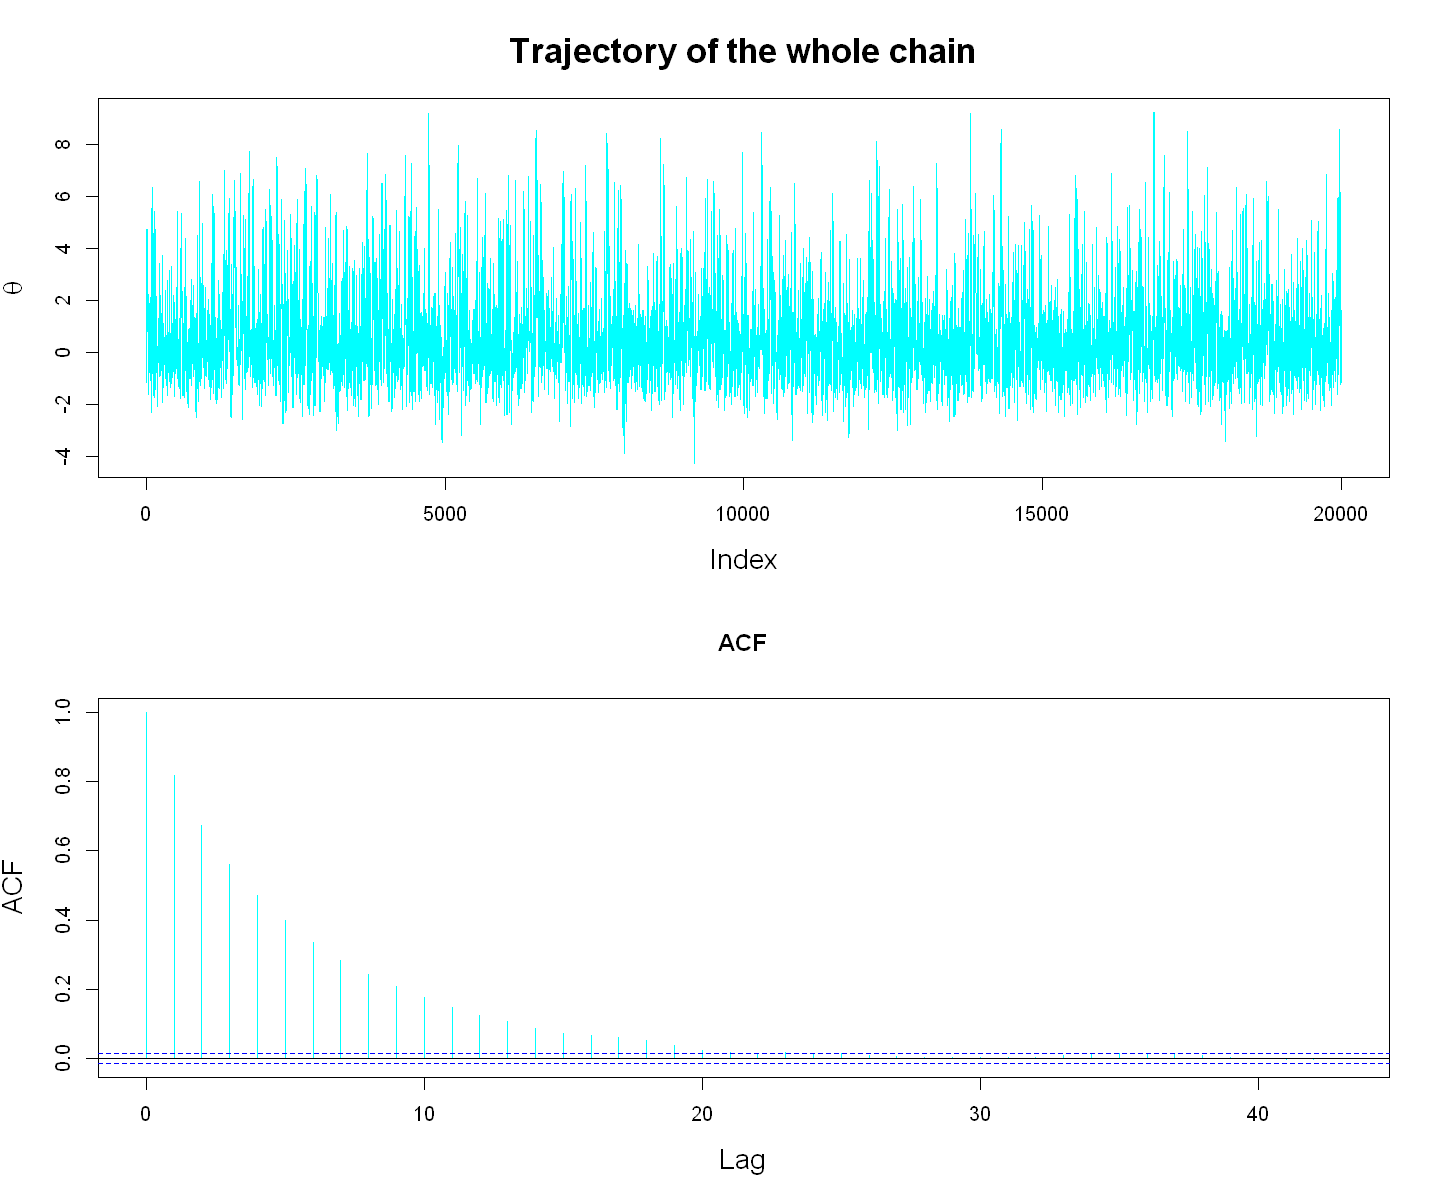

In [6]:
options(repr.plot.width=12,repr.plot.height=10)
old.par<-par(mfrow=c(2,1))
plot(M.chain,type="l",col="cyan",ylab=expression(theta),
     main="Trajectory of the whole chain",cex.main=1.7,cex.lab=1.4)
acf(M.chain,col="cyan",main="ACF",cex.main=1.7,cex.lab=1.4)
par(old.par)

## Histogram of the chain

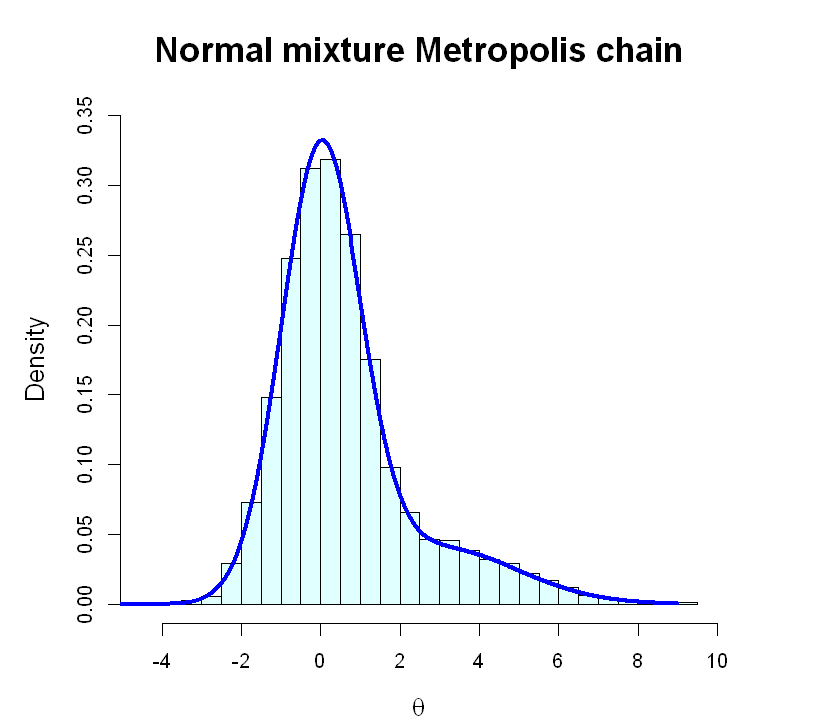

In [7]:
options(repr.plot.width=7.0,repr.plot.height=6.0)
old.par<-par(mar=c(4,5,4,5))
hist(M.chain,freq=FALSE,ylim=c(0,0.35),breaks=35,xlab=expression(theta),
    main="Normal mixture Metropolis chain",col="LightCyan",
    cex.main=1.7,cex.lab=1.3)
u<-seq(-6,9,length=600)
lines(u,g(u),lwd=3.5,col="blue")
par(old.par)

## Discard burnIn segment

In [8]:
burnIn<-5000
M.chain.1<-M.chain[(burnIn+1):length(M.chain)]

## New traceplot and ACF

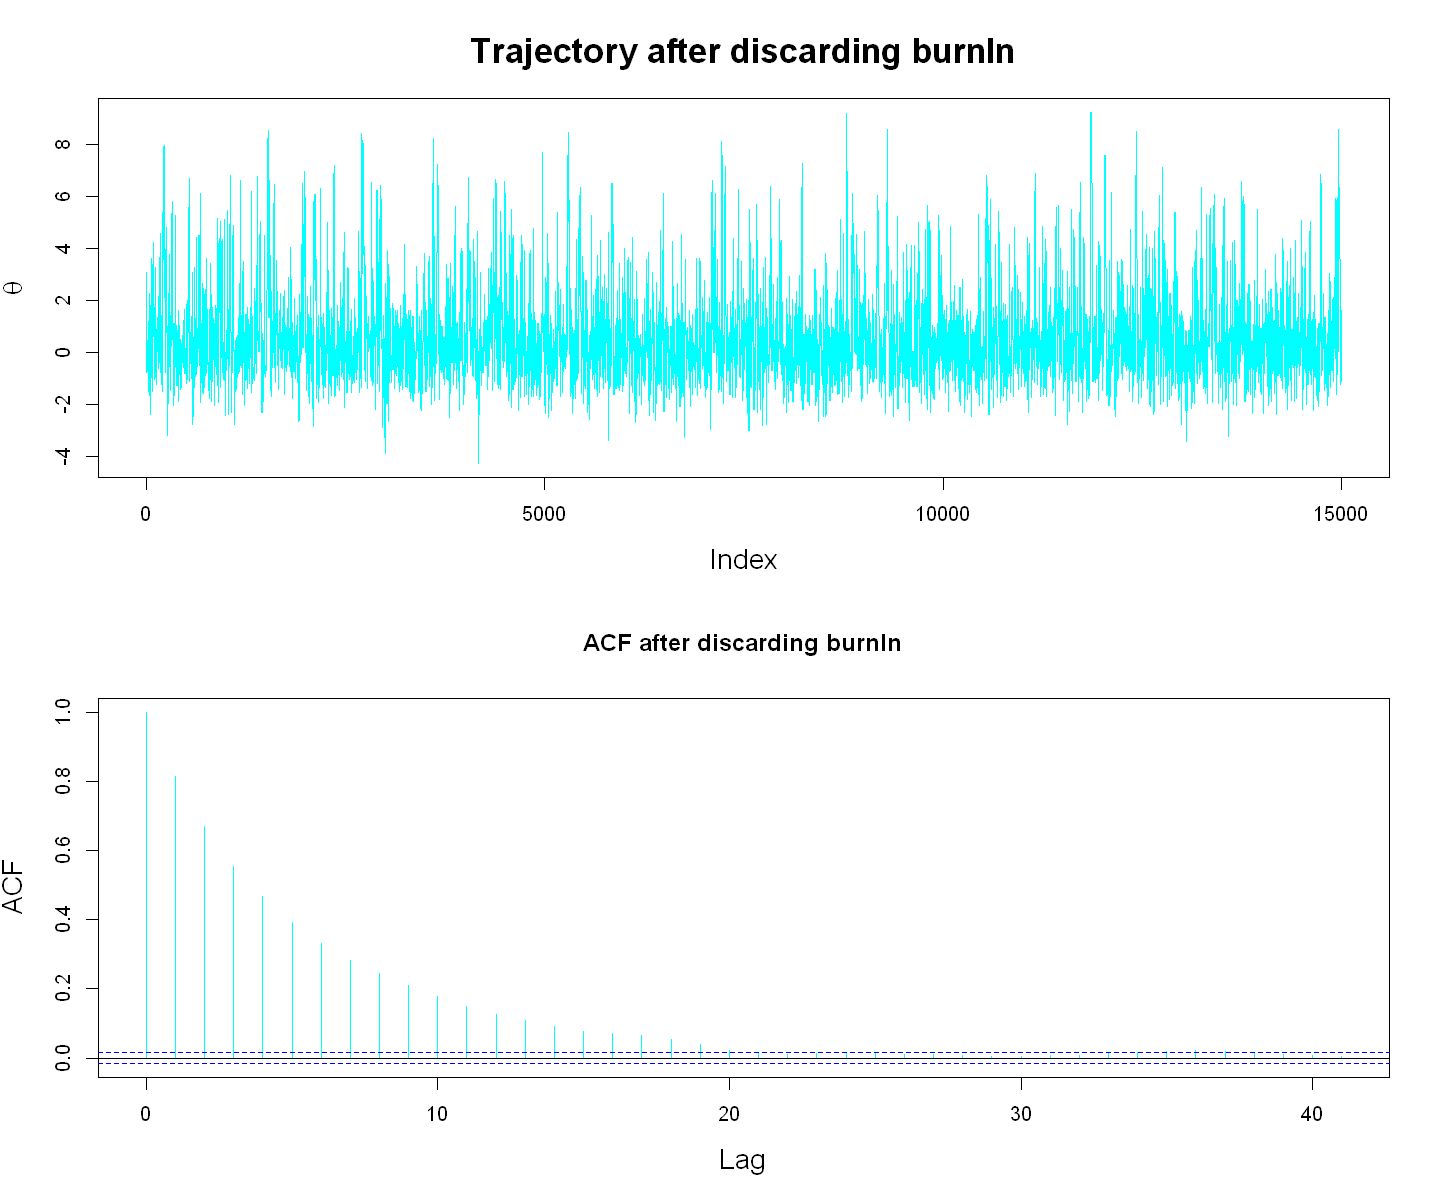

In [9]:
options(repr.plot.width=12,repr.plot.height=10)
old.par<-par(mfrow=c(2,1))
plot(M.chain.1,type="l",col="cyan",ylab=expression(theta),
    main="Trajectory after discarding burnIn",
    cex.main=1.7,cex.lab=1.4)
acf(M.chain.1,col="cyan",main="ACF after discarding burnIn",
    cex.main=1.7,cex.lab=1.4)
par(old.par)

## Histogram of the chain after discarding burnIn

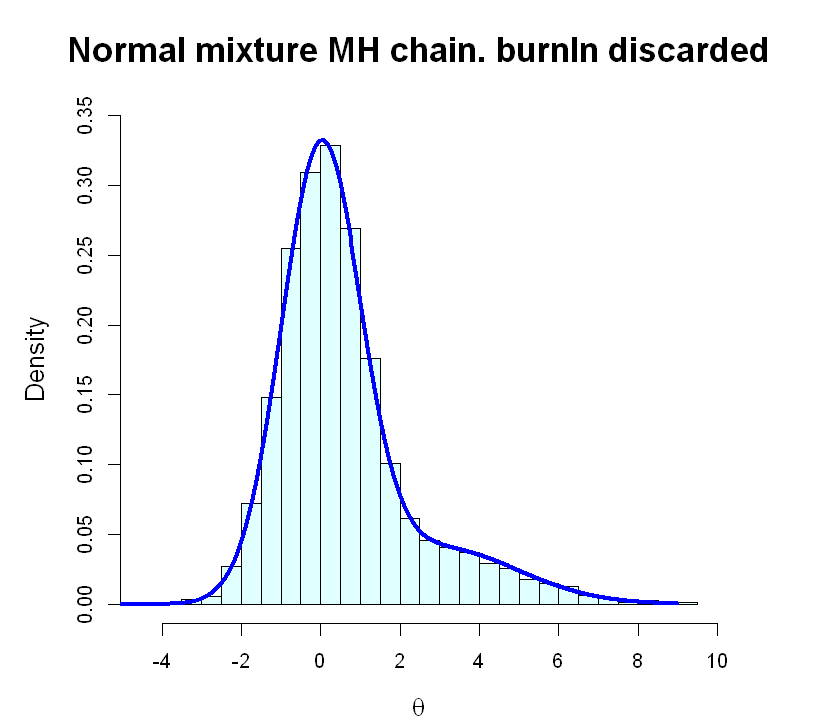

In [10]:
options(repr.plot.width=7.0,repr.plot.height=6.0)
old.par<-par(mar=c(4,5,4,5))
hist(M.chain.1,freq=FALSE,ylim=c(0,0.35),breaks=35,xlab=expression(theta),
    main="Normal mixture MH chain. burnIn discarded",col="LightCyan",
    cex.main=1.7,cex.lab=1.3)
u<-seq(-6,9,length=600)
lines(u,g(u),lwd=3.5,col="blue")
par(old.par)

# (3) Metropolis-Hastings with an independent candidate generation 

A Metropolis-Hastings algorithm with a candidate proposal kernel which does not depend on the previous state $\theta$, 
that is, $ k(\theta'\,|\,\theta)=q(\theta')$, is called _independent candidate M-H algorithm._ Here the candidate proposal kernel is:

$$
    k(\theta'\,|\,\theta)=q(\theta')=\exp\{-\frac{1}{2}\,\left(\theta'/3\right)^{2}\},
$$

a $\textrm{N}(0,3^{2})$ pdf. 

With it, the probability of acceptance is:
    
$$
    \min\left\{1,\frac{h_{x}(\theta')\cdot k(\theta\,|\,\theta')}{h_{x}(\theta)\cdot k(\theta'\,|\,\theta)}\right\}
        =\min\left\{1,\frac{h_{x}(\theta')\cdot q(\theta)}{h_{x}(\theta)\cdot q(\theta')}\right\}.
$$

_Hint:_ Use $\theta=0.4448$ as the start value in the trajectory. 

Test the algorithm with several values of chain length and _burn-in_ initial discarded segment.

## Candidate proposal kernel

In [11]:
rq<-function(){rnorm(1,mean=0,sd=3)}
dq<-function(t){dnorm(t,mean=0,sd=3)}

## M-H chain iteration

With target $ g(t)$, and independent candidate density $\operatorname{dq}(t)$ and generation of random numbers $\operatorname{rq}()$.

In [12]:
MH<-function(N.iterations,g,dq,rq,start){
    epsilon<-1.0e-10
    chain<-rep(0,N.iterations+1)
    chain[1]<-start
    for (i in 1:N.iterations){
        t<-chain[i]
        t1<-rq()
        if (g(t)*dq(t1)<epsilon)
            prob<-1
        else
            prob<-min(1,(g(t1)*dq(t))/(g(t)*dq(t1)))
        if (runif(1) < prob)
            chain[i+1]<-t1
        else
            chain[i+1]<-t
        }
    return(chain)
    }

## Run the M-H chain iteration

In [13]:
N.iterations<-20000
burnIn<-6000
start<-1.0
MH.chain<-MH(N,g,dq,rq,start)

## Traceplot, ACF

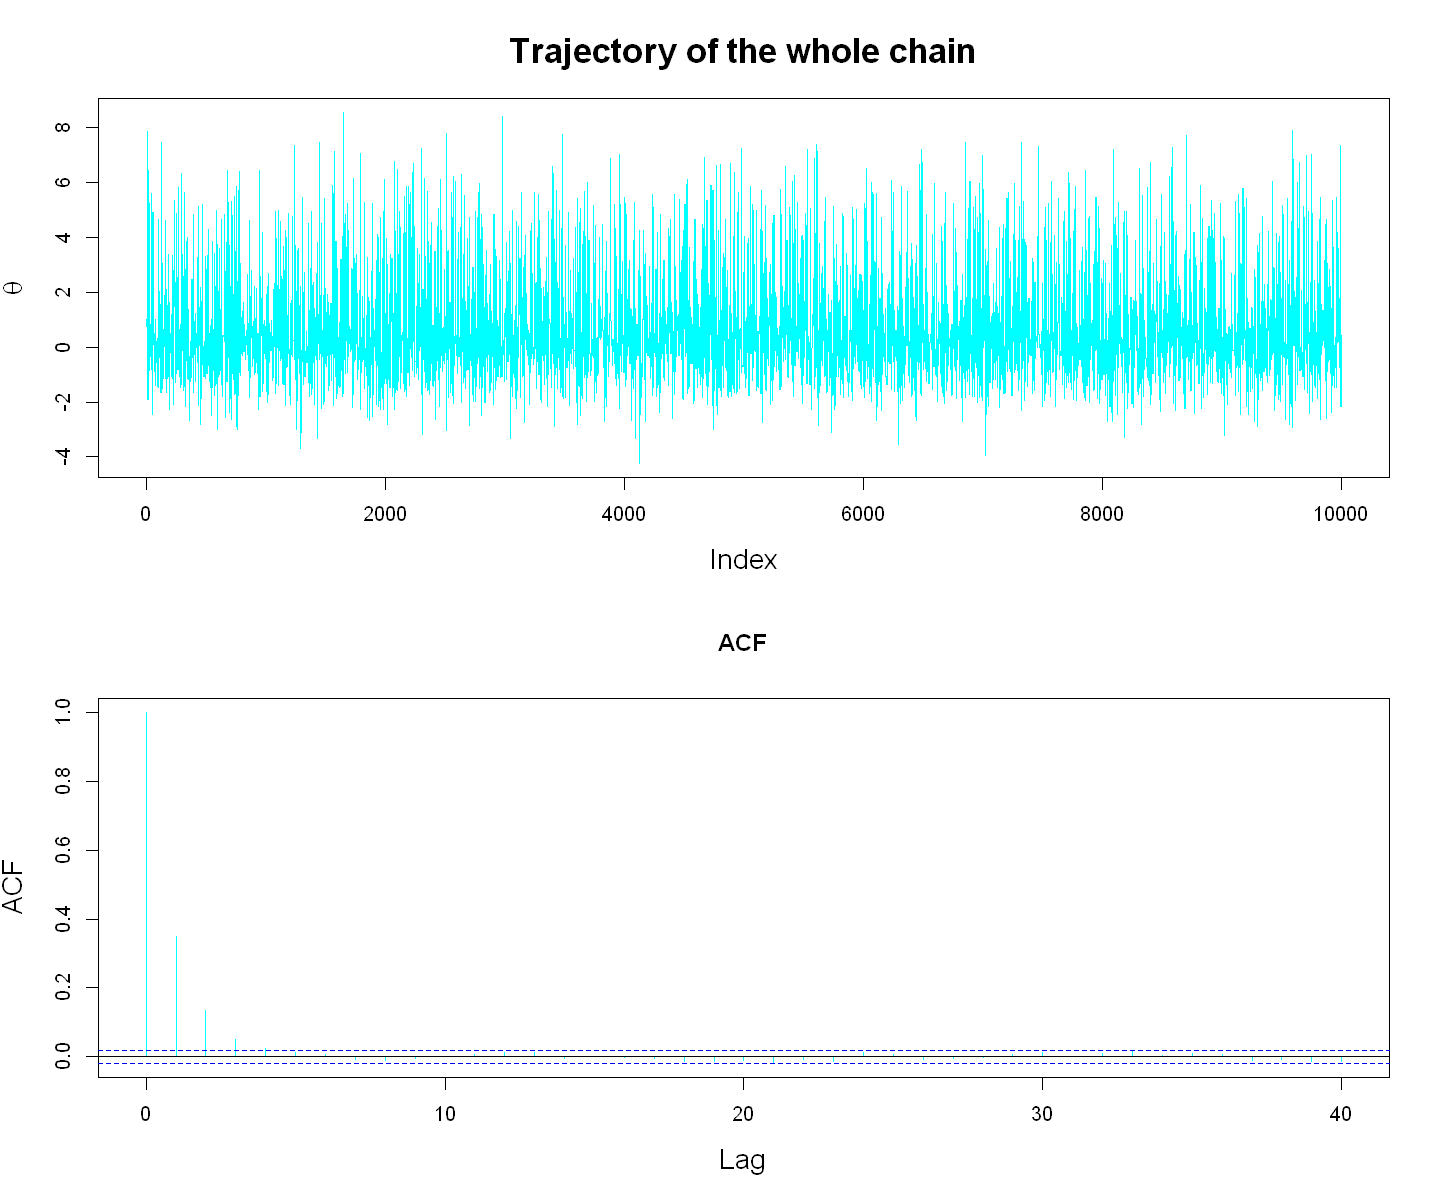

In [14]:
options(repr.plot.width=12,repr.plot.height=10)
old.par<-par(mfrow=c(2,1))
plot(MH.chain,type="l",col="cyan",ylab=expression(theta),
     main="Trajectory of the whole chain",cex.main=1.7,cex.lab=1.4)
acf(MH.chain,col="cyan",main="ACF",cex.main=1.7,cex.lab=1.4)
par(old.par)

## Histogram of the M-H chain

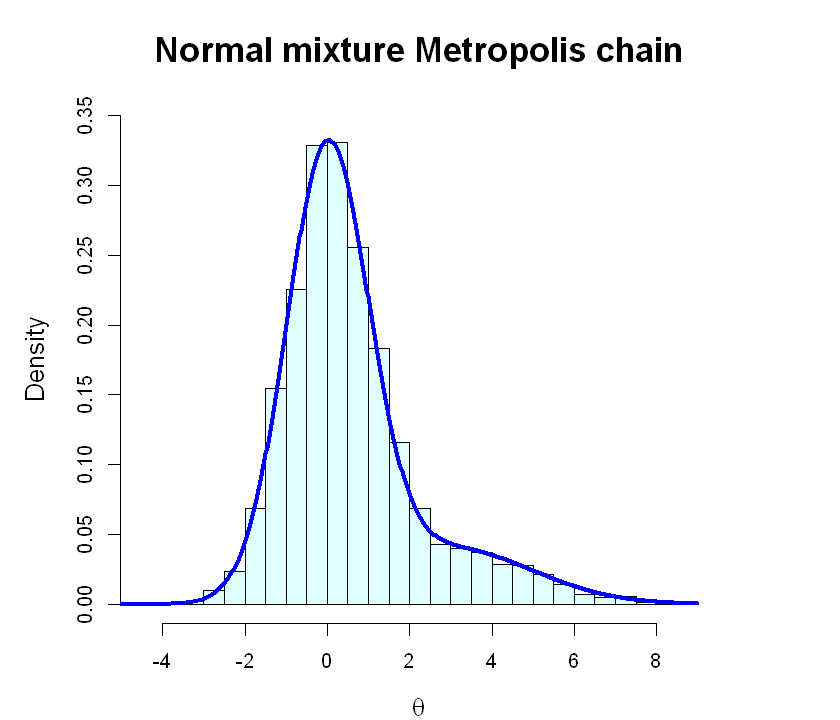

In [15]:
options(repr.plot.width=7.0,repr.plot.height=6.0)
old.par<-par(mar=c(4,5,4,5))
hist(MH.chain,freq=FALSE,ylim=c(0,0.35),breaks=35,xlab=expression(theta),
    main="Normal mixture Metropolis chain",col="LightCyan",
    cex.main=1.7,cex.lab=1.3)
u<-seq(-6,9,length=600)
lines(u,g(u),lwd=3.5,col="blue")
par(old.par)

## Discard `burnIn` segment

In [16]:
burnIn<-6000
MH.chain.1<-MH.chain[(burnIn+1):length(MH.chain)]

## New traceplot and ACF

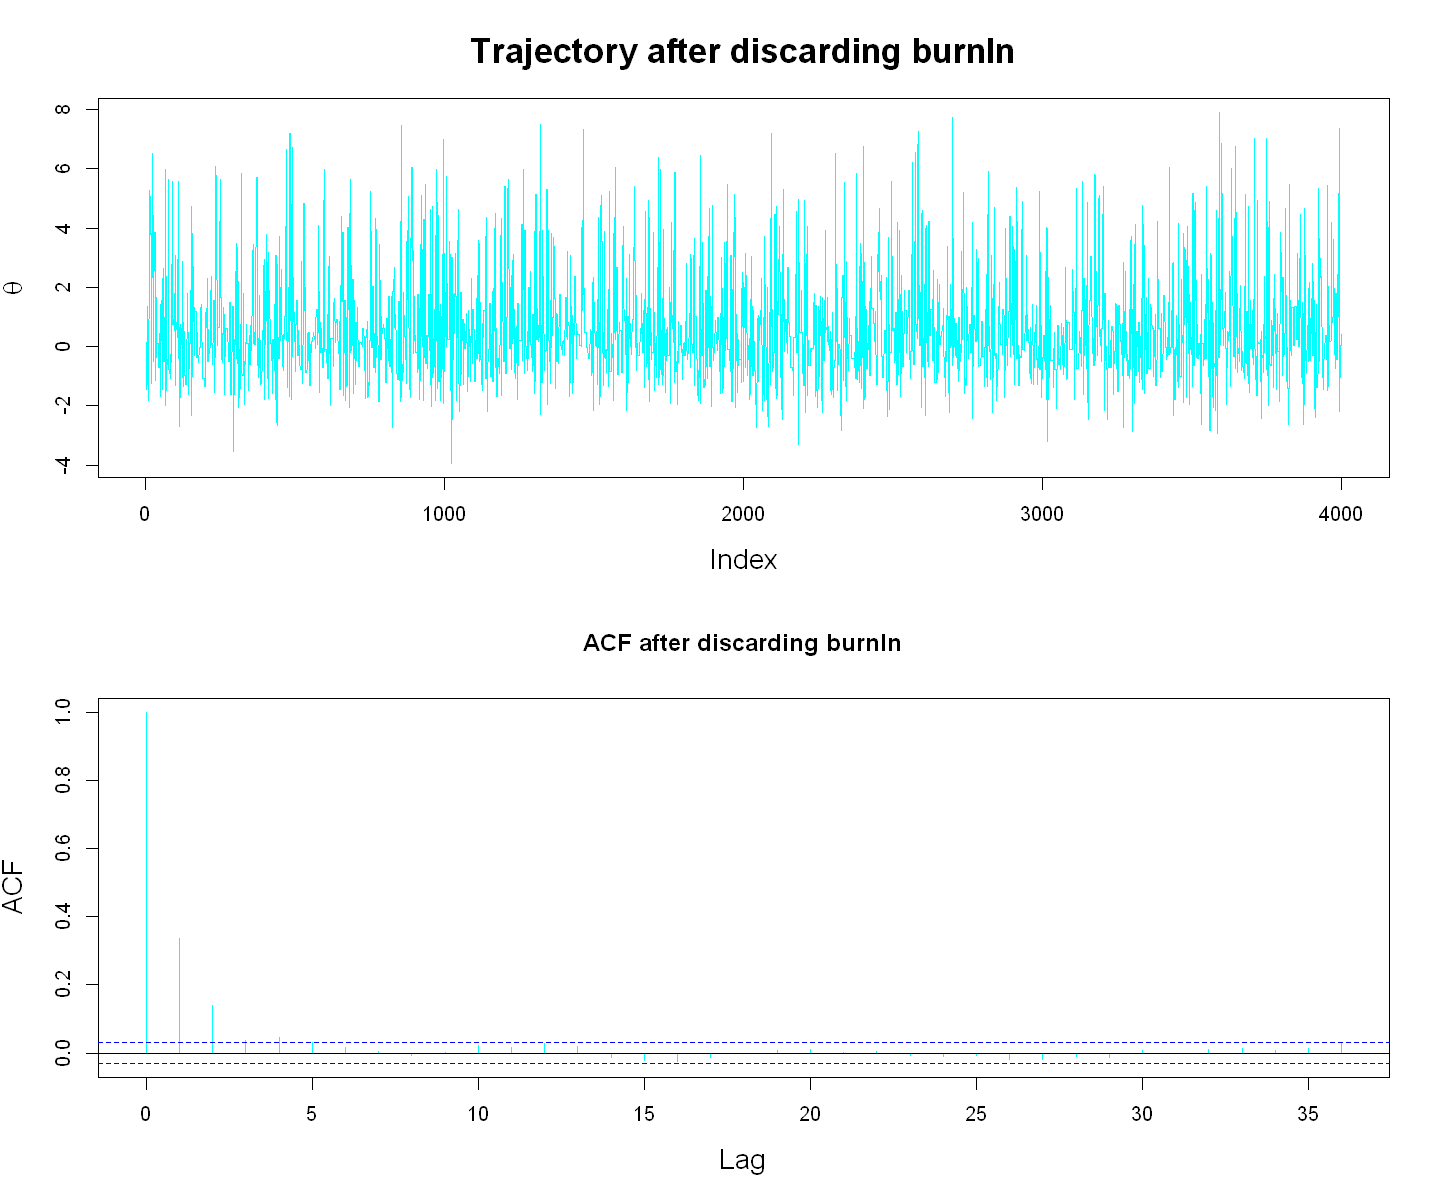

In [17]:
options(repr.plot.width=12,repr.plot.height=10)
old.par<-par(mfrow=c(2,1))
plot(MH.chain.1,type="l",col="cyan",ylab=expression(theta),
    main="Trajectory after discarding burnIn",
    cex.main=1.7,cex.lab=1.4)
acf(MH.chain.1,col="cyan",main="ACF after discarding burnIn",
    cex.main=1.7,cex.lab=1.4)
par(old.par)

## Histogram of the chain after discarding the `burnIn` segment

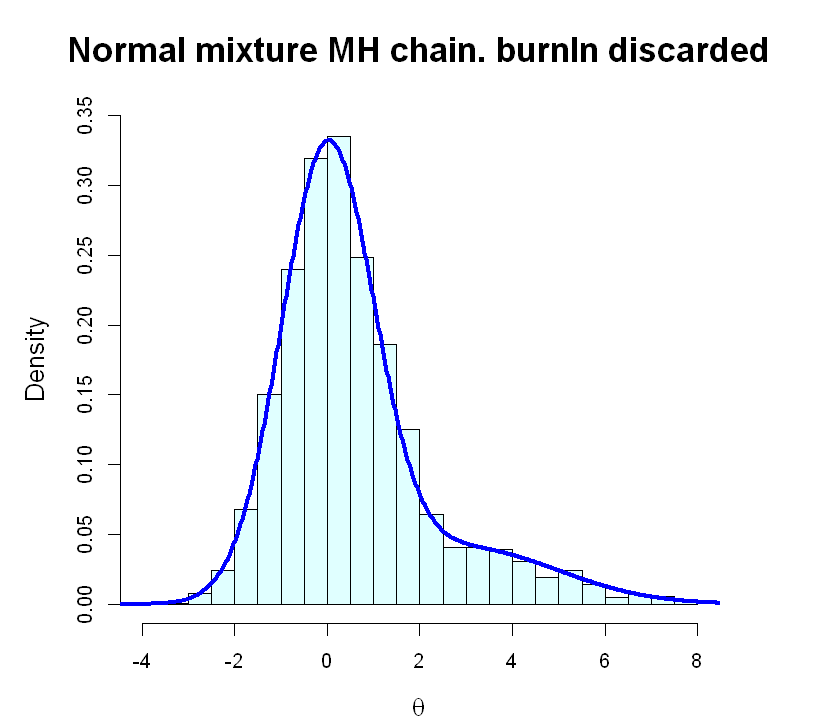

In [18]:
options(repr.plot.width=7.0,repr.plot.height=6.0)
old.par<-par(mar=c(4,5,4,5))
hist(MH.chain.1,freq=FALSE,ylim=c(0,0.35),breaks=35,xlab=expression(theta),
    main="Normal mixture MH chain. burnIn discarded",col="LightCyan",
    cex.main=1.7,cex.lab=1.3)
u<-seq(-6,9,length=600)
lines(u,g(u),lwd=3.5,col="blue")
par(old.par)